In [2]:
import os

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
def load_data(path):
    return np.load(path).astype('float32')

In [4]:
path_processed_data = '../../examples/box_w_aggr/data/processed/'

path_input = os.path.join(path_processed_data, 'input.npy')
path_target = os.path.join(path_processed_data, 'target.npy')

inputs = load_data(path_input)
targets = load_data(path_target)

In [5]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.1, random_state=1)

inputs_train.shape, targets_train.shape, inputs_test.shape, targets_test.shape

((362, 128, 128, 5), (362, 128, 128, 1), (41, 128, 128, 5), (41, 128, 128, 1))

In [6]:
def scale_target(weight):
    def scale(input, target):
        target = tf.where(target<0, tf.zeros_like(target), target)
        return input, target*weight
    return scale

In [7]:
def make_dataset(inputs, targets, batch_size, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
    if is_train: dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(scale_target(1e4))
    return dataset

In [8]:
dataset_train = make_dataset(inputs_train, targets_train, 16, is_train=True)
dataset_test = make_dataset(inputs_test, targets_test, 16)

In [9]:
for i, t in dataset_train.take(5):
    print(i.shape)
    print(t.numpy().min(), t.numpy().max())
    print()

(16, 128, 128, 5)
0.0 5.579631

(16, 128, 128, 5)
0.0 5.565762

(16, 128, 128, 5)
0.0 5.0745344

(16, 128, 128, 5)
0.0 4.54053

(16, 128, 128, 5)
0.0 6.364011



In [76]:
class GoogleNetLayer(tf.keras.layers.Layer):
    def __init__(self, n_filters, kernel_sizes, strides, name, dtype='float32', autocast=False, **kwargs):
        super(GoogleNetLayer, self).__init__(name=name, dtype=dtype, **kwargs)

        default_params = dict(filters=n_filters, strides=strides, padding='same', activation='relu')

        self.conv1 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[0], **default_params)
        self.conv2 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[1], **default_params)
        self.conv3 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[2], **default_params)
        self.concat = tf.keras.layers.Concatenate()
    
    def call(self, inputs):
        c1 = self.conv1(inputs)
        c2 = self.conv1(inputs)
        c3 = self.conv1(inputs)
        return self.concat([c1, c2, c3])

In [77]:
class GoogleNetTransposedLayer(tf.keras.layers.Layer):
    def __init__(self, n_filters, kernel_sizes, strides, name, dtype='float32', **kwargs):
        super(GoogleNetTransposedLayer, self).__init__(name=name, dtype=dtype, **kwargs)

        default_params = dict(filters=n_filters, strides=strides, padding='same', activation='relu')

        self.convt1 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[0], **default_params)
        self.convt2 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[1], **default_params)
        self.convt3 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[2], **default_params)
        self.concat = tf.keras.layers.Concatenate()
    
    def call(self, inputs):
        c1 = self.convt1(inputs)
        c2 = self.convt1(inputs)
        c3 = self.convt1(inputs)
        return self.concat([c1, c2, c3])

In [78]:
class UnetModel(tf.keras.Model):
    def __init__(self, kernel_sizes, filter_sizes):
        super(UnetModel, self).__init__()
        self.d1_layer = GoogleNetLayer(filter_sizes[0], kernel_sizes, strides=(1,1), name='d1')
        self.d2_layer = GoogleNetLayer(filter_sizes[1], kernel_sizes, strides=(2,2), name='d2')
        self.d3_layer = GoogleNetLayer(filter_sizes[2], kernel_sizes, strides=(1,1), name='d3')
        self.d4_layer = GoogleNetLayer(filter_sizes[3], kernel_sizes, strides=(2,2), name='d4')

        self.u4_layer = GoogleNetTransposedLayer(filter_sizes[3], kernel_sizes, strides=(1,1), name='u4')
        self.u3_layer = GoogleNetTransposedLayer(filter_sizes[2], kernel_sizes, strides=(2,2), name='u3')
        self.u2_layer = GoogleNetTransposedLayer(filter_sizes[1], kernel_sizes, strides=(1,1), name='u2')
        self.u1_layer = GoogleNetTransposedLayer(filter_sizes[0], kernel_sizes, strides=(2,2), name='u1')

        self.u0_layer = tf.keras.layers.Conv2D(1, (1,1), activation='linear', padding='same', name='u1')

        self.concat1 = tf.keras.layers.Concatenate()
        self.concat3 = tf.keras.layers.Concatenate()

    def call(self, inputs):
        d1 = self.d1_layer(inputs)
        d2 = self.d2_layer(d1)
        d3 = self.d3_layer(d2)
        d4 = self.d4_layer(d3)

        u4 = self.u4_layer(d4)
        u3 = self.u3_layer(u4)
        c3 = self.concat3([u3, d3])
        u2 = self.u2_layer(c3)
        u1 = self.u1_layer(u2)
        c1 = self.concat1([u1, d1])

        return self.u0_layer(c1)

In [81]:
def get_compiled_UnetModel(kernel_sizes, filter_sizes, input_shape, learning_rate):
    model = UnetModel(kernel_sizes, filter_sizes)
    model.build(input_shape)

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(
        loss='mean_absolute_error',  # mean_squared_error
        optimizer=optimizer, 
        metrics=['mean_squared_error']
    ) 
    return model

In [82]:
kernel_sizes = [(7,7), (17,17), (21,21)]
filter_sizes = [4, 8, 16, 32]
input_shape = (None, 400, 400, 5)

learning_rate = 1e-3

model = get_compiled_UnetModel(kernel_sizes, filter_sizes, input_shape, learning_rate)

model.summary()

Model: "unet_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d1 (GoogleNetLayer)          multiple                  984       
_________________________________________________________________
d2 (GoogleNetLayer)          multiple                  4712      
_________________________________________________________________
d3 (GoogleNetLayer)          multiple                  18832     
_________________________________________________________________
d4 (GoogleNetLayer)          multiple                  75296     
_________________________________________________________________
u4 (GoogleNetTransposedLayer multiple                  150560    
_________________________________________________________________
u3 (GoogleNetTransposedLayer multiple                  75280     
_________________________________________________________________
u2 (GoogleNetTransposedLayer multiple                 

In [83]:
epochs = 2

history = model.fit(
    dataset_train, 
    epochs=epochs,
    validation_data=dataset_test,
)

Epoch 1/2
23/23 [==============================] - 34s 1s/step - loss: 0.7206 - mean_absolute_error: 0.6038 - val_loss: 0.4366 - val_mean_absolute_error: 0.5441
Epoch 2/2
23/23 [==============================] - 33s 1s/step - loss: 0.4253 - mean_absolute_error: 0.5360 - val_loss: 0.4212 - val_mean_absolute_error: 0.5263


NameError: name 'history_all' is not defined

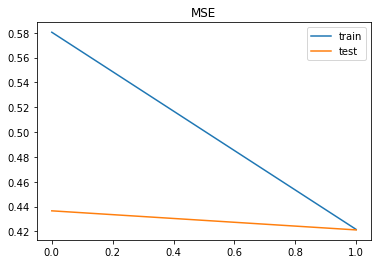

In [87]:
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='test')
plt.title('MSE')
plt.legend()

In [90]:
path = '../../test_model'
model.save(path)

INFO:tensorflow:Assets written to: ../../test_model/assets
INFO:tensorflow:Assets written to: ../../test_model/assets


In [15]:
def plot_example(target, pred):
    vmax = min(np.max(pred), np.max(target))
    vmin = 0

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
    ax0.imshow(np.squeeze(pred), vmin=vmin, vmax=vmax, cmap='seismic')
    ax0.set_title('prediction')

    im = ax1.imshow(np.squeeze(target), vmin=vmin, vmax=vmax, cmap='seismic')
    ax1.set_title('target')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
    fig.colorbar(im, cax=cbar_ax)

In [12]:
model = tf.keras.models.load_model('saved_model')

In [13]:
dataset = make_dataset(inputs_test, targets_test, 1)
pred = model.predict(dataset)

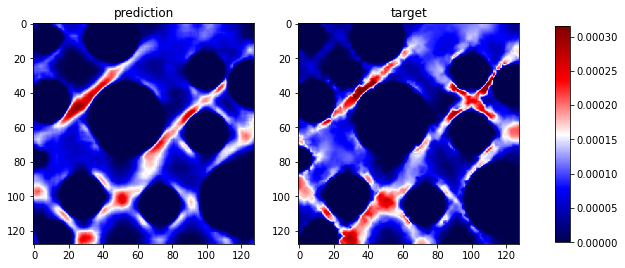

In [18]:
idx = 5
plot_example(targets_test[idx], pred[idx]*1e-4)